**Set environment**

In [1]:
suppressWarnings(suppressMessages(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import FCC data

In [2]:
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.screened.fcc.total.tsv"
fpath = file.path(fdiry, fname)

dat = read_tsv(fpath, show_col_types=FALSE)

dat_peak_atac_fcc_total = dat
print(dim(dat))
head(dat)

[1] 732434      7


Chrom,Start,End,Peak,Score,Assay_Type,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
chr1,100006256,100006880,chr1:100006256-100006880,-0.01311792,ASTARR,ASTARR_T
chr1,100010437,100010915,chr1:100010437-100010915,-0.80687947,ASTARR,ASTARR_T
chr1,10002087,10003910,chr1:10002087-10003910,-0.34892859,ASTARR,ASTARR_T
chr1,100021298,100021629,chr1:100021298-100021629,-1.03799571,ASTARR,ASTARR_T
chr1,100023727,100023976,chr1:100023727-100023976,-0.19100207,ASTARR,ASTARR_T
chr1,100027983,100029702,chr1:100027983-100029702,-0.18001582,ASTARR,ASTARR_T


In [3]:
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.summary.chromHMM.tsv"
fpath = file.path(fdiry, fname)

dat = read_tsv(fpath, show_col_types = FALSE)

dat_peak_atac_annotation = dat
print(dim(dat))
head(dat)

[1] 262805      7


Peak,Annotation,Label,Count,Region,Score,Note
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
chr1:10015-10442,ChromHMM,Quies,1,chr1:0-16000,1,Quies
chr1:14253-14645,ChromHMM,Quies,1,chr1:0-16000,1,Quies
chr1:16015-16477,ChromHMM,TxWk,1,chr1:16000-16200,1,TxWk
chr1:17237-17772,ChromHMM,TxWk,1,chr1:17400-17600,1,TxWk
chr1:28903-29613,ChromHMM,Quies,1,chr1:17600-118400,1,Quies
chr1:30803-31072,ChromHMM,Quies,1,chr1:17600-118400,1,Quies


## Scale and arrange

**Score**

In [4]:
dat = dat_peak_atac_fcc_total
dat = dat %>% 
    dplyr::group_by(Assay_Type) %>%
    dplyr::mutate(ZScore = scale(Score))

dat_peak_score = dat
print(dim(dat))
head(dat)

[1] 732434      8


Chrom,Start,End,Peak,Score,Assay_Type,Assay_Label,ZScore
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,"<dbl[,1]>"
chr1,100006256,100006880,chr1:100006256-100006880,-0.01311792,ASTARR,ASTARR_T,-0.1144482
chr1,100010437,100010915,chr1:100010437-100010915,-0.80687947,ASTARR,ASTARR_T,-1.3754998
chr1,10002087,10003910,chr1:10002087-10003910,-0.34892859,ASTARR,ASTARR_T,-0.6479517
chr1,100021298,100021629,chr1:100021298-100021629,-1.03799571,ASTARR,ASTARR_T,-1.7426750
chr1,100023727,100023976,chr1:100023727-100023976,-0.19100207,ASTARR,ASTARR_T,-0.3970533
chr1,100027983,100029702,chr1:100027983-100029702,-0.18001582,ASTARR,ASTARR_T,-0.3795994


**Annotation**

In [5]:
vec_txt_label = c(
    "Tss"        = "Active TSS", 
    "TssFlnk"    = "Flanking TSS", 
    "TssFlnkD"   = "Flanking TSS", 
    "TssFlnkU"   = "Flanking TSS", 
    "Enh1"       = "Enhancer", 
    "Enh2"       = "Enhancer", 
    "EnhG1"      = "Enhancer in gene", 
    "EnhG2"      = "Enhancer in gene", 
    "Tx"         = "Transcription",
    "TxWk"       = "Weak transcription", 
    "Biv"        = "Bivalent",
    "ReprPC"     = "Repressed by Polycomb", 
    "ZNF/Rpts"   = "ZNF genes repeats",
    "Quies"      = "Quiescent", 
    "Het"        = "Heterochromatin")

dat = dat_peak_atac_annotation
vec = vec_txt_label

dat = dat %>% dplyr::mutate(Label = dplyr::recode(Label, !!!vec))
dat = dat %>% dplyr::select(Peak, Label)

dat_peak_annot = dat
print(dim(dat))
head(dat)

[1] 262805      2


Peak,Label
<chr>,<chr>
chr1:10015-10442,Quiescent
chr1:14253-14645,Quiescent
chr1:16015-16477,Weak transcription
chr1:17237-17772,Weak transcription
chr1:28903-29613,Quiescent
chr1:30803-31072,Quiescent


**Merge**

In [6]:
dat = dat_peak_score
dat = dat %>% 
    dplyr::left_join(dat_peak_annot, by="Peak", relationship="many-to-many") %>%
    dplyr::select(Peak, ZScore, Assay_Type, Label) %>%
    dplyr::mutate(Label = ifelse(is.na(Label), "None", Label))

### assign and show
dat_peak_score_label = dat
print(dim(dat))
head(dat)

[1] 846160      4


Peak,ZScore,Assay_Type,Label
<chr>,"<dbl[,1]>",<chr>,<chr>
chr1:100006256-100006880,-0.1144482,ASTARR,Quiescent
chr1:100010437-100010915,-1.3754998,ASTARR,Quiescent
chr1:10002087-10003910,-0.6479517,ASTARR,Repressed by Polycomb
chr1:100021298-100021629,-1.7426750,ASTARR,Quiescent
chr1:100023727-100023976,-0.3970533,ASTARR,Quiescent
chr1:100027983-100029702,-0.3795994,ASTARR,Quiescent


**Check**

In [7]:
dat = dat_peak_score
dat = dat %>% 
    dplyr::group_by(Assay_Type) %>% 
    dplyr::summarize(
        Mean = mean(ZScore), 
        Var = var(ZScore),
        .groups = "drop"
    )
dat

Assay_Type,Mean,Var
<chr>,<dbl>,"<dbl[,1]>"
ASTARR,2.419471e-17,1
CRISPRi-Growth,7.708293e-18,1
CRISPRi-HCRFF,-9.224380e-20,1
ENCODE-E2G_Benchmark,-8.636538e-18,1
ENCODE-E2G_Prediction,-1.331934e-17,1
LMPRA,-3.392632e-17,1
TMPRA,2.561034e-17,1
WSTARR,7.705577e-18,1


In [8]:
fun_bstrap_interveral = function(vec_num, fun = `mean`, num_iteration = 1000, num_seed = 123){
    ### init
    set.seed(num_seed)
    
    ### column: num_iteraction
    ### row:    length(vec_num)
    mat = replicate(
        num_iteration,
        sample(vec_num, replace = TRUE)
    )

    vec = apply(mat, 2, fun)
    res = quantile(vec, probs = c(0, 0.025, 0.25, 0.5, 0.75, 0.975, 1))
    res = c(res, mean(vec))
    names(res) = c("Min", "Ci95_Lw", "Q1", "Q2", "Q3", "Ci95_Up", "Max", "Mean")
    return(res)
}

In [9]:
dat = dat_peak_score_label

lst = split(dat, dat$Assay_Type)
lst = lapply(lst, function(dat){
    lst_inner = split(dat$ZScore, dat$Label)
    lst_inner = lapply(lst_inner, fun_bstrap_interveral)
    dat = bind_rows(lst_inner, .id = "Labels")
    return(dat)
})

dat = bind_rows(lst, .id = "Assay_Type")
dat_peak_score_summary = dat
head(dat)

Assay_Type,Labels,Min,Ci95_Lw,Q1,Q2,Q3,Ci95_Up,Max,Mean
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASTARR,Active TSS,0.6544483,0.6698423,0.68434331,0.69217180,0.69987254,0.71508587,0.73180009,0.69220961
ASTARR,Bivalent,-0.4578212,-0.4445108,-0.43521376,-0.43004229,-0.42462984,-0.41433259,-0.40503444,-0.42991183
ASTARR,Enhancer,0.9196870,0.9264180,0.93732119,0.94247013,0.94797521,0.95899346,0.96623693,0.94257255
ASTARR,Enhancer in gene,-0.1679541,-0.1543910,-0.14426616,-0.13696693,-0.13021500,-0.11799573,-0.10638820,-0.13701262
ASTARR,Flanking TSS,0.1232442,0.1323432,0.14242199,0.14833024,0.15387801,0.16418945,0.17445957,0.14828712
ASTARR,Heterochromatin,-0.1232127,-0.1090275,-0.08433915,-0.07164078,-0.05847417,-0.03507649,-0.01741124,-0.07160558


In [10]:
dat = dat_peak_score_summary
table(dat$Labels)


           Active TSS              Bivalent              Enhancer 
                    8                     8                     8 
     Enhancer in gene          Flanking TSS       Heterochromatin 
                    8                     8                     8 
                 None             Quiescent Repressed by Polycomb 
                    8                     8                     8 
        Transcription    Weak transcription     ZNF genes repeats 
                    8                     8                     8 

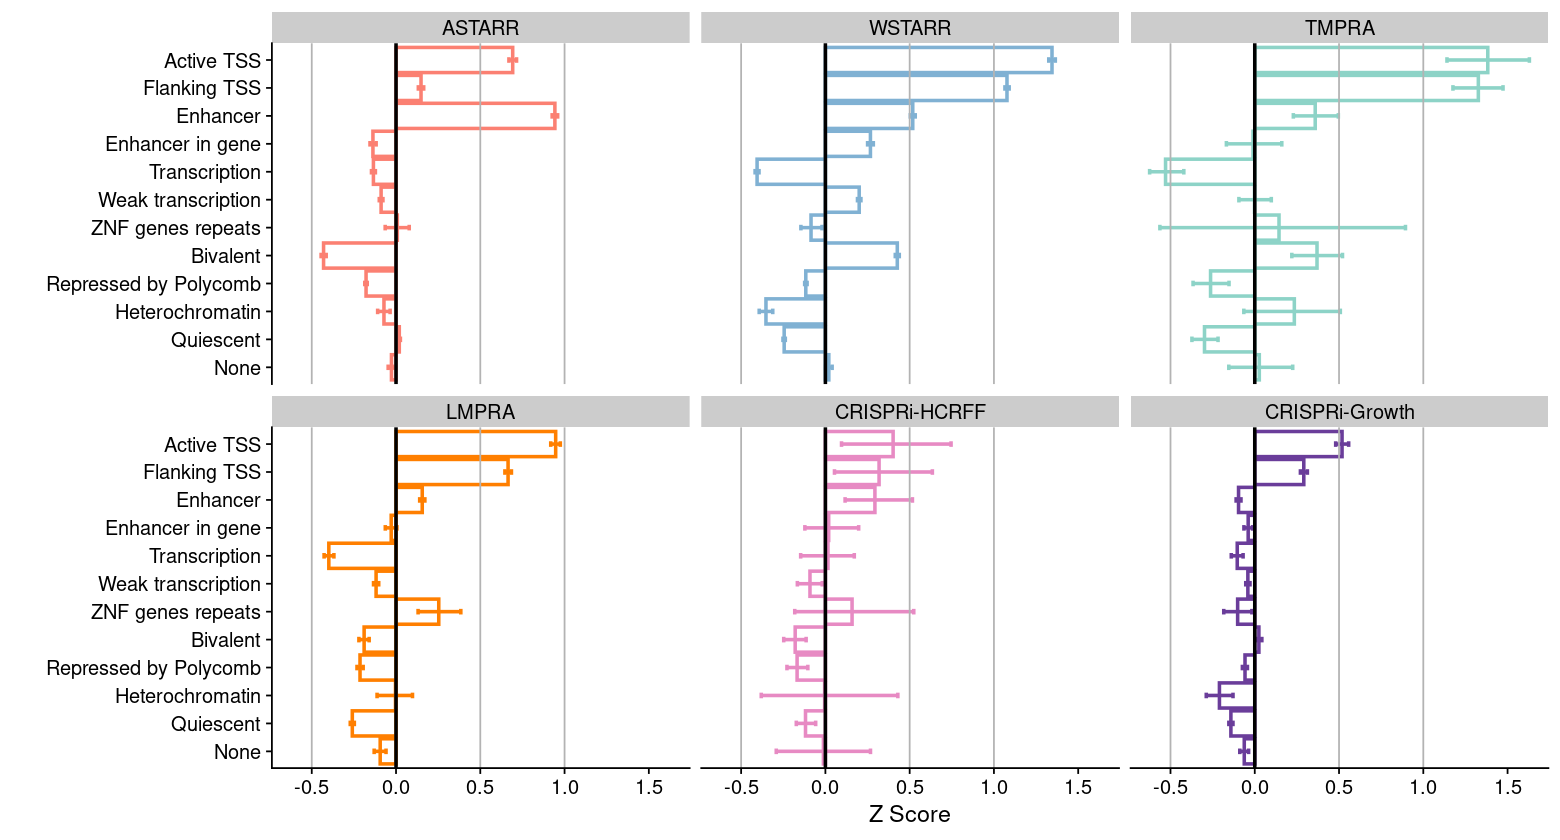

In [12]:
vec_txt_assay = c("ASTARR", "WSTARR", "TMPRA", "LMPRA", "CRISPRi-HCRFF", "CRISPRi-Growth")

vec_txt_label = c(
    "Active TSS", 
    "Flanking TSS", 
    "Enhancer", 
    "Enhancer in gene", 
    "Transcription",
    "Weak transcription", 
    "ZNF genes repeats",
    "Bivalent",  
    "Repressed by Polycomb", 
    "Heterochromatin",
    "Quiescent",
    "None"
)

vec_txt_color = c(
    "ASTARR" = "#fb8072", 
    "WSTARR" = "#80b1d3", 
    "TMPRA"  = "#8dd3c7", 
    "LMPRA"  = "#ff7f00",
    "CRISPRi-HCRFF"  = "#e78ac3", 
    "CRISPRi-Growth" = "#6a3d9a")

dat = dat_peak_score_summary
dat = dat %>% 
    dplyr::filter(Assay_Type %in% vec_txt_assay) %>%
    dplyr::filter(Labels     %in% vec_txt_label) %>%
    dplyr::mutate(
        Labels     = factor(Labels,     levels=rev(vec_txt_label)),
        Assay_Type = factor(Assay_Type, levels=vec_txt_assay)
    )

gpt = ggplot(dat) + 
    geom_col(
        aes(
            x     = Labels, 
            y     = Mean,
            group = Assay_Type,
            color = Assay_Type
        ),
        position = "dodge",
        fill = "white",
        linewidth = 1
    ) +
    geom_errorbar(
        aes(
            x     = Labels, 
            ymin  = Ci95_Lw, 
            ymax  = Ci95_Up,
            group = Assay_Type, 
            color = Assay_Type
           ), 
        width = 0.2,
        linewidth  = 1
    ) +
    geom_hline(yintercept = 0, color="black", size = 1) +
    geom_hline(yintercept = c(1, 0.5, -0.5), color="grey70") +
    labs(x="", y="Z Score") +
    scale_color_manual(values = vec_txt_color) +
    theme_cowplot() +
    coord_flip() +
    facet_wrap(~Assay_Type, nrow=2) +
    theme(legend.position = "None")

options(repr.plot.height=7, repr.plot.width = 13)
print(gpt)